### Text Mining Homework 4

#### Problem 1

Please put IMDB sentiment (positive, negative) of movie review data (IMDB Dataset.csv) as a dependent variable. You want to evaluate model accuracy after establishing a model with the sentiment score for the review obtained using the sentiment dictionary(lexicon) as an independent variable. Among the entire data, only the first 1000 data are used for convenience. Among these, the first 70% is used as train data to build a model, and the remaining 30% is used as test data to evaluate accuracy. For accuracy evaluation, accuracy ( accuracy rate) is used.

In [1]:
import numpy as np
import pandas as pd

In [2]:
review = pd.read_csv('../Data/IMDBDataset.csv')
review.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


(1) Build a logistic regression model with the sentiment score obtained using the AFINN dictionary as an independent variable, and evaluate model accuracy.

In [3]:
train_y = review['sentiment'][0:700]  # 70% train dataset
test_y = review['sentiment'][700:1000] # 30% test dataset

In [4]:
from afinn import Afinn
afinn = Afinn()
n = 1000
score_list = []
for row in review['review'][0:n]:
    afscore = afinn.score(row)
    score_list.append(afscore)
train_x = score_list[0:700]
test_x = score_list[700:1000]

In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = 42)
model.fit(np.array(train_x).reshape(-1,1), np.array(train_y))

LogisticRegression(random_state=42)

In [7]:
print(f'The model train score is {model.score(np.array(train_x).reshape(-1,1), np.array(train_y)) : .4f}')

The model train score is  0.7557


In [8]:
print(f'The model test score is {model.score(np.array(test_x).reshape(-1,1), np.array(test_y)) : .4f}')

The model test score is  0.7633


In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
y_pred = model.predict(np.array(test_x).reshape(-1,1))
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

    negative       0.74      0.75      0.74       137
    positive       0.79      0.77      0.78       163

    accuracy                           0.76       300
   macro avg       0.76      0.76      0.76       300
weighted avg       0.76      0.76      0.76       300


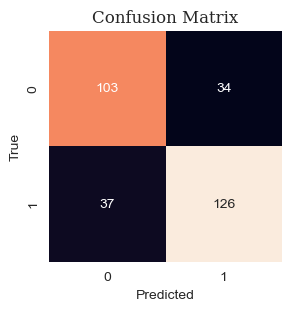

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(test_y, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()

(2) First, preprocess the review sentence using the following preprocessing way 

In [11]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

NRC = pd.read_csv('../Data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', 
                  engine = "python", 
                  header = None, 
                  sep = "\t")
NRC = NRC[(NRC != 0).all(1)] 
NRC = NRC.reset_index(drop=True)

# data preprocessing
tokenizer = RegexpTokenizer('[\w]+')
stop_words = stopwords.words('english')
p_stemmer = PorterStemmer()

n = 1000
score_list = []

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
NRC

,0,1,2
0,abacus,trust,1
1,abandon,fear,1
2,abandon,negative,1
3,abandon,sadness,1
4,abandoned,anger,1
...,...,...,...
13896,zest,anticipation,1
13897,zest,joy,1
13898,zest,positive,1
13899,zest,trust,1


Second, assign scores 1 and -1 to words that match positive and negative words in the NRC dictionary, respectively. 

In [12]:
for row in review['review'][0:n]:
    raw = row.lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in stop_words] # remove stopwords
    match_words = [x for x in stopped_tokens if x in list(NRC[0])] # match w/ lexicon

    emotion=[]
    for i in match_words:
        temp = list(NRC.iloc[np.where(NRC[0] == i)[0],1])  # emotion list
        for j in temp:
            emotion.append(j)
    sentiment_result1 = pd.Series(emotion).value_counts()
    try: neg = sentiment_result1.negative  # negative word count
    except: neg = 0
    try: pos = sentiment_result1.positive # positive word count
    except: pos = 0
    score = pos-neg   
    score_list.append(score)

Third, generate the sentiment score by adding the positive and negative scores as an independent variable. 

In [13]:
df_score = pd.DataFrame([score_list], index = ['lexion']).T
df_score = pd.concat([df_score, review.sentiment[:1000]], axis = 1)
df_score

,lexion,sentiment
0,-11,positive
1,13,positive
2,4,positive
3,-3,negative
4,17,positive
...,...,...
995,1,positive
996,-2,negative
997,-2,negative
998,0,negative


Finally, evaluate the accuracy of a logistic regression model with the sentiment score obtained using the procedures above. (using NRC-Emotion-Lexicon-Wordlevel-v0.92.txt)

In [14]:
X_train = df_score['lexion'][:700]
X_test = df_score['lexion'][700:]

y_train = df_score['sentiment'][:700]
y_test = df_score['sentiment'][700:]

model = LogisticRegression()
model.fit(np.array(X_train).reshape(-1,1), y_train)

LogisticRegression()

In [15]:
print(f'The model train score is {model.score(np.array(X_train).reshape(-1,1), np.array(y_train)) : .4f}')

The model train score is  0.6714


In [16]:
print(f'The model test score is {model.score(np.array(X_test).reshape(-1,1), np.array(y_test)) : .4f}')

The model test score is  0.6633


In [17]:
y_pred = model.predict(np.array(X_test).reshape(-1,1))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.61      0.74      0.67       137
    positive       0.73      0.60      0.66       163

    accuracy                           0.66       300
   macro avg       0.67      0.67      0.66       300
weighted avg       0.68      0.66      0.66       300


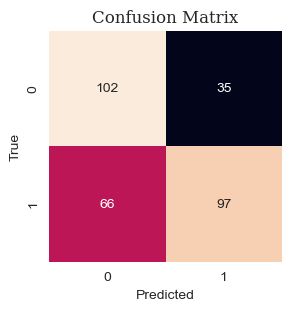

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()

#### Problem 2

Please put IMDB sentiment (positive, negative) of movie review data (IMDB Dataset.csv) as a dependent variable. The (raw frequency based or TF-IDF modified frequency based) Term-Document data for reviews work as independent variables. Among the entire data, only the first 1000 data are used for convenience. Among these, the first 70% is used as train data to build a model, and the remaining 30% is used as test data to evaluate accuracy. For accuracy evaluation, an accurate rate is used. Answer the questions using the data that went through the preprocessing process below.

**Preprocessing process**

1. HTML Remove tags and extract only text
2. Convert non-alphabetic characters to spaces
3. Convert to lower case
4. stop words Removed (using nltk 's English stopwords)
5. One Combining strings with spaces (using join)

In [19]:
from bs4 import BeautifulSoup
import html5lib
import warnings
warnings.filterwarnings('ignore')

# use initial n reviews only
n = 1000 # originally total 50000 reviews
reviews = []
for row in review['review'][0:n]:
    review1 = BeautifulSoup(row, 'html5lib').get_text()
    reviews.append(review1)

start with alphabet small letters

In [20]:
import re

review_list = []
for row1 in reviews:
    review2 = re.sub('[^a-zA-z]',' ', row1)
    review3 = review2.lower() # transform into small letters
    review_list.append(review3)

Tokenization

In [21]:
token_list = []
for row2 in review_list:
    review4 = row2.split()
    token_list.append(review4)

removing stopwords

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
sentence_words = []
for w in token_list:
    sword = []
    for wi in w:
        if not wi in stopwords.words('english'): sword.append(wi)
    sentence_words.append(sword)

In [24]:
print(len(sentence_words))
print(sentence_words[0])

1000
['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'hooked', 'right', 'exactly', 'happened', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'go', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'called', 'oz', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards', 'privacy', 'high', 'agenda', 'em', 'city', 'home', 'many', 'aryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'scuffles', 'death', 'stares', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', 'dare', 'forget', 'pretty', 'pictures', 'painted', 'mainstream', 'audiences', 'forget', 'charm',

In [25]:
clean_review = []
for sentence in sentence_words:
    s = ' '
    clean_review.append(s.join(sentence))

In [26]:
n = 1000
review1 = clean_review[0:n]

x_input = review1
y_output = review['sentiment']

X_train = x_input[0:700]
X_test = x_input[700:1000]

y_train = y_output[0:700]
y_test = y_output[700:1000]

(1) A logistic regression model in which the vector-processed value of documents with word appearance frequency is used as an independent variable

Build and evaluate model accuracy (Hint: CounterVectorizer use)

Counter Vectorizer

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

vectorized = CountVectorizer()
vectors = vectorized.fit(X_train)

In [28]:
X_train_vectorizer = vectors.transform(X_train)

Classification with Logistic Regression Model

In [29]:
model = LogisticRegression()
model.fit(X_train_vectorizer, y_train)

LogisticRegression()

In [30]:
print(f'The model train score is {model.score(X_train_vectorizer, y_train) : .4f}')

The model train score is  1.0000


In [31]:
print(f'The model test score is {model.score(vectors.transform(X_test), y_test) : .4f}')

The model test score is  0.8300


In [32]:
y_pred = model.predict(vectors.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.79      0.85      0.82       137
    positive       0.87      0.81      0.84       163

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300


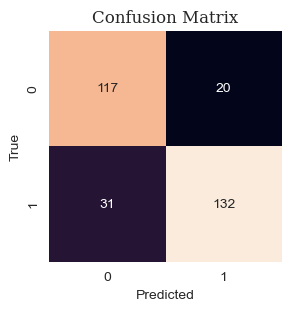

In [33]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()

(2) Build and evaluate the accuracy of the model by building a logistic regression model with TF-IDF vectors as independent variables

(Hint: Tfidf Vectorizer use)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(stop_words = stop_words).fit(X_train)
X_train_vectorized_tfidf = tfidf_vector.transform(X_train)

In [35]:
model = LogisticRegression()
model.fit(X_train_vectorized_tfidf, y_train)

LogisticRegression()

In [36]:
print(f'The model train score is {model.score(X_train_vectorized_tfidf, y_train) : .4f}')

The model train score is  0.9914


In [37]:
print(f'The model test score is {model.score(tfidf_vector.transform(X_test), y_test) : .4f}')

The model test score is  0.8333


In [38]:
y_pred = model.predict(tfidf_vector.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.76      0.92      0.83       137
    positive       0.92      0.76      0.83       163

    accuracy                           0.83       300
   macro avg       0.84      0.84      0.83       300
weighted avg       0.85      0.83      0.83       300


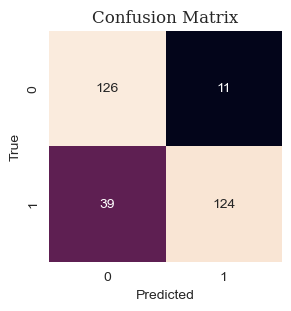

In [39]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix', fontsize = 12, fontfamily = 'Serif')
plt.show()